In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from unidecode import unidecode


from nltk.util import ngrams
from nltk import word_tokenize
from collections import Counter

import spacy
from spacy.matcher import PhraseMatcher
from wordcloud import WordCloud
import emoji

## Visualisation de nos données

In [2]:
# Importation des données
df = pd.read_csv('../Data_clean/tweets_fr_clean.csv').dropna(subset=['tweet_clean'])
# Transformation de la colonne 'date' au format adéquat
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
# Défini l'indice avec la colonne 'date'
df.set_index(df['date'], inplace = True)
df.drop('date', axis =1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37146 entries, 2021-04-21 to 2021-04-18
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   time            37146 non-null  object
 1   tweet           37146 non-null  object
 2   tweet_clean     37146 non-null  object
 3   hashtags        37146 non-null  object
 4   likes_count     37146 non-null  int64 
 5   retweets_count  37146 non-null  int64 
 6   day             37146 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.3+ MB


In [3]:
df.head()

,time,tweet,tweet_clean,hashtags,likes_count,retweets_count,day
date,,,,,,,
2021-04-21,22:29:44,Jean Michel incisif face aux 12 frondeurs de l...,jean michel incisif face frondeur teamom jamais,"['superleague', 'teamom']",5,1,21
2021-04-21,22:29:01,Beppe #Marotta (AD Inter) lance un cri d’alarm...,beppe marotta ad clubs_signataires lancer cri ...,"['marotta', 'superleague']",56,18,21
2021-04-21,22:27:10,"Avec l'échec du projet de #SuperLeague, la mor...",echec projet mort visage olasm,"['superleague', 'olasm']",6,0,21
2021-04-21,22:26:00,Jean Michel trop heureux de la mort de la #Sup...,jean michel trop heureux mort teamom,"['superleague', 'teamom']",7,0,21
2021-04-21,22:25:48,3-1 pour la Juve contre Parme (2 Coupes UEFA) ...,clubs_signataires contre parme coupe uefa comp...,['superleague'],2,2,21


### Data Visualisation

#### Nombre de tweets par jour dans notre échantillon

In [4]:
num_tweets = pd.DataFrame(df.value_counts('day'), index = df.value_counts('day').index).sort_values('day').reset_index()
num_tweets.columns = ['Day', 'Occurences']

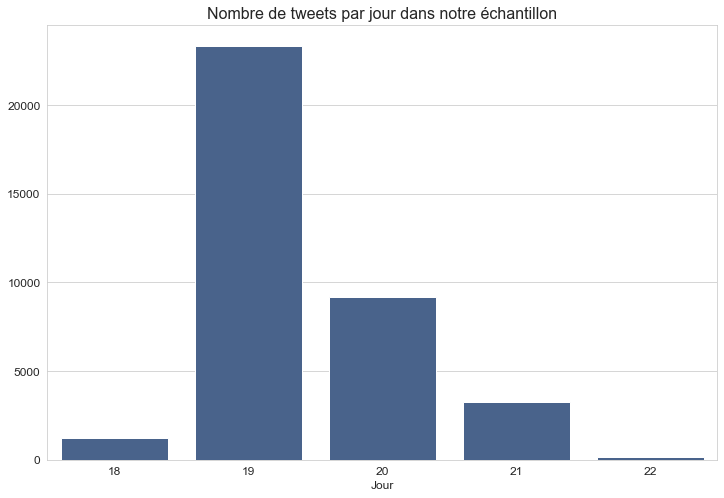

In [5]:
# Paramètre graphique
sns.set_style("whitegrid")

plt.figure(figsize=(12,8))

plot = sns.barplot(y=num_tweets["Occurences"], 
                   x=num_tweets["Day"],
                   color='#3e6096')

plt.xlabel('Jour', fontsize=12)
plt.ylabel('')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.title("Nombre de tweets par jour dans notre échantillon", fontsize=16) 
plt.savefig("../Streamlit_App/graphs/tweets_par_jour.png")

- Nos données concernent surtout le 19 avril 2021

#### Tweets classés en fonction du nombre de likes reçu 

In [6]:
pd.set_option('max_colwidth', 140)

df.sort_values('likes_count', ascending = False).head(10)[['tweet', 'tweet_clean', 'likes_count', 'retweets_count']]

,tweet,tweet_clean,likes_count,retweets_count
date,,,,
2021-04-19,Je pense au mec qui doit expliquer le bordel de la #SuperLeague à Ousmane qui vient de se réveiller https://t.co/EqtRPwNJOR,mec devoir expliquer bordel ousmane venir reveiller,36897,6039
2021-04-19,Le tireur de coup franc de l’équipe de France en coupe du monde 2022 #SuperLeague https://t.co/bTiRwQhikM,tireur coup franc equipe france coupe monde,30293,7397
2021-04-19,"Mbappé quand il va entendre ""et le 7 tu sors pas du stade à la fin du match"" après un doublé en demi de LDC contre Vaulx-en-velin #Super...",mbapper entendre sortir stade fin match double demi ldc contre vaulx en velin,29566,6601
2021-04-19,#SuperLeague Mon fils en 2035 : Papa c’est quoi la finale de la Ldc ajd ? Moi : https://t.co/jYZklmCqJx,fils papa finale ldc ajd,26915,9259
2021-04-19,Manuel Neuer qui arrête un penalty face à Sarcelles en demi-finale de ligue des champions #SuperLeague https://t.co/xnfotWnWnE,manuel neuer arrete penalty face sarcelle demi finale ligue champion,26245,8293
2021-04-19,Créé par des pauvres voler par des riches L’histoire du football. #SuperLeague https://t.co/AffY6QkA2K,creer pauvre voler riche histoire,22217,6040
2021-04-19,Là quoi ? 🤮🤮🤮 La richesse ne suffit pas pour atteindre le bonheur. #SuperLeague,richesse suffire atteindre bonheur,18732,3100
2021-04-19,Pogba et Dembele privé de cdm qui flex a la can des quartiers #SuperLeague https://t.co/wEabbgQNoF,pogba dembele priver cdm flex can quartier,16426,4500
2021-04-19,Problèmes de racisme : UEFA : « c’est compliqué de bannir un club. » Problèmes d’argent : UEFA : « on va bannir 12 clubs dans les proc...,probleme racisme uefa compliquer bannir probleme argent uefa bannir prochain heure,14972,5745


- Difficile d’émettre  un jugement à partir de ces tweets, car renvoient souvent à des liens.
- Néanmoins on peut déjà identifier trois tweets négatifs. Dans ces tweets, on y observe les mots "voler", "richesse" utlisée de façon péjorative, de comparaison avec des affaires liés au racisme

#### Identification des hashtags utilisés dans notre échantillon

- Ici, les hashtags #superleague sont exclues car présent dans chaque tweets, soit plus de 37000 fois.

In [7]:
hashtag = [i for i in df['hashtags'].str.replace('[', '').str.replace(']', '').str.replace("'", '')]

dico = {}

for i in hashtag:
    hashs = i.split(',')
    
    for j in hashs:
        dico[j] = 0

dico = {i.strip():k for i,k in dico.items()}
    
for i in hashtag:
    hashs = i.split(',')
    
    for j in hashs:
        dico[j.strip()] += 1
        
#dico

/var/folders/ff/1c0cg3ts35bgty96d6kxvdp00000gn/T/ipykernel_96279/2857871221.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  hashtag = [i for i in df['hashtags'].str.replace('[', '').str.replace(']', '').str.replace("'", '')]


In [8]:
hashtags = pd.DataFrame(dico.values(),  index = dico.keys()).reset_index()
hashtags.columns = ['hashtag', 'Occurences']

hashtags = hashtags.sort_values('Occurences', ascending=False)[1:11]

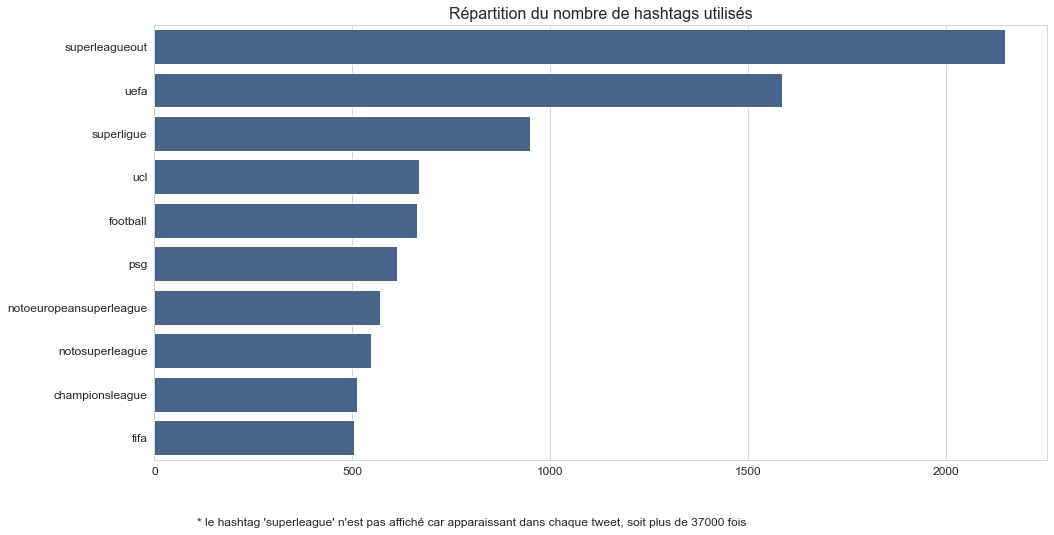

In [9]:
# Paramètre graphique
sns.set_style("whitegrid")

plt.figure(figsize=(16,8))

plot = sns.barplot(x=hashtags["Occurences"], 
                   y=hashtags["hashtag"],
                   color='#3e6096')

plt.xlabel('')
plt.ylabel("")
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.title("Répartition du nombre de hashtags utilisés", fontsize = 16) 
plt.figtext(0.4, 0.01, "* le hashtag 'superleague' n'est pas affiché car apparaissant dans chaque tweet, soit plus de 37000 fois", ha="center", fontsize=12)
plt.savefig("../Streamlit_App/graphs/hashtags.jpg", bbox_inches='tight', dpi = 300)

- Les hashtags #superleagueout, #notoeuropeansuperleague, #notosuperleague, signalent le fort rejet de ce projet.

### Data Visualisation

#### Unigram

- Visualisation des mots les plus utilisés dans notre échantillon, à l'exclusion des stops words, ou des mots pas assez discriminant (tel que superleague par exemple, présent dans tous nos tweets).
- Il est important de signaler que les termes comme "clubs_signataires", "clubs_non_signataires", "florentino_perez", "andrea_agnelli", "superleagueout" sont des termes que nous avons créés dans le notebook 1, dans le but de rassembler les différents alias utilisés et de mieux mesurer l'impact de chacun de ses termes, qui autrement auraient été "dilués".

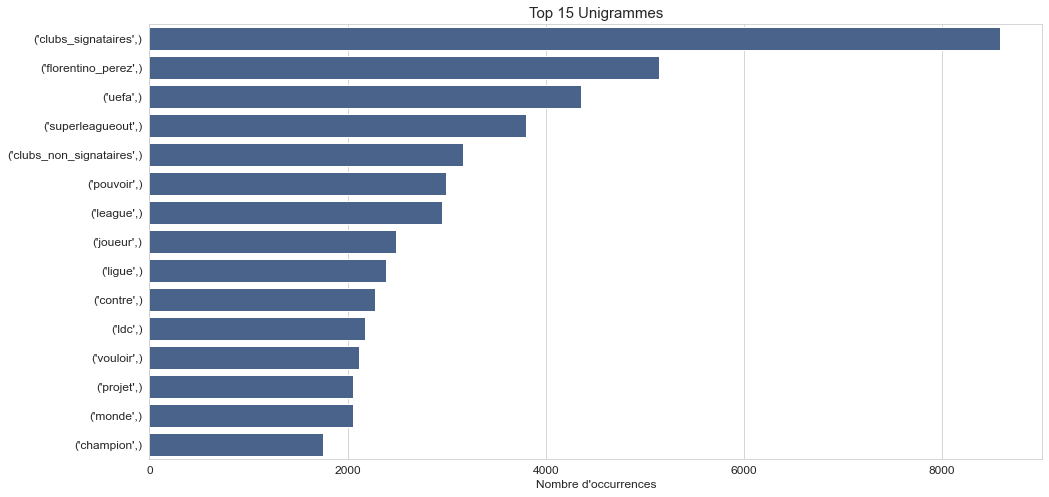

In [10]:
# Récupération sous forme de liste de tous les articles
list_tweet = df["tweet_clean"].dropna().tolist()

# Tokenisation des articles
list_tokens = ' '.join(list_tweet).split()

# Identification et compte des bigrams
list_bigrams = list(ngrams(list_tokens, 1)) 
counter = Counter(list_bigrams)


# Création d'un dataframe contenant le top 15 bigramme les plus fréquents
df_plot = pd.DataFrame(counter.most_common(15))

# Création du graphique
plt.figure(figsize=(16,8))

plot = sns.barplot(x=df_plot[1], 
                   y=df_plot[0],
                   color='#3e6096')

plt.xlabel("Nombre d'occurrences", fontsize = 12)
plt.ylabel("", fontsize = 12)
plt.title(f"Top 15 Unigrammes", fontsize = 15)
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.savefig("../Streamlit_App/graphs/unigram.png", bbox_inches='tight', dpi = 300)

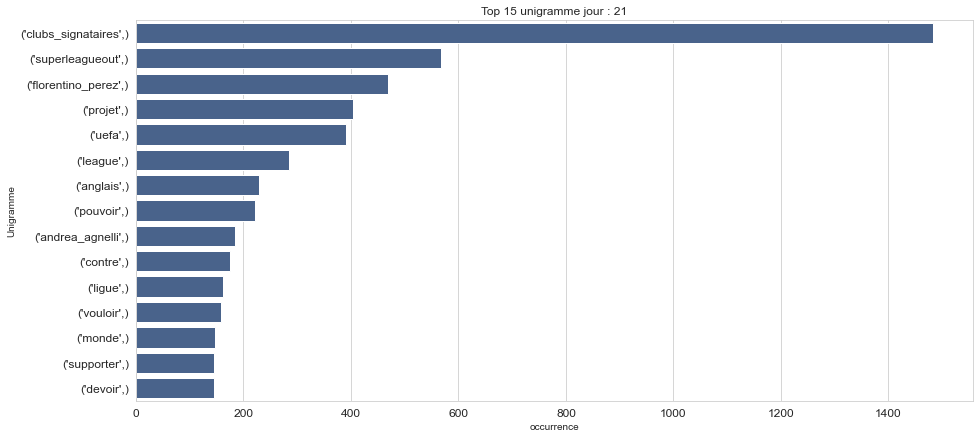

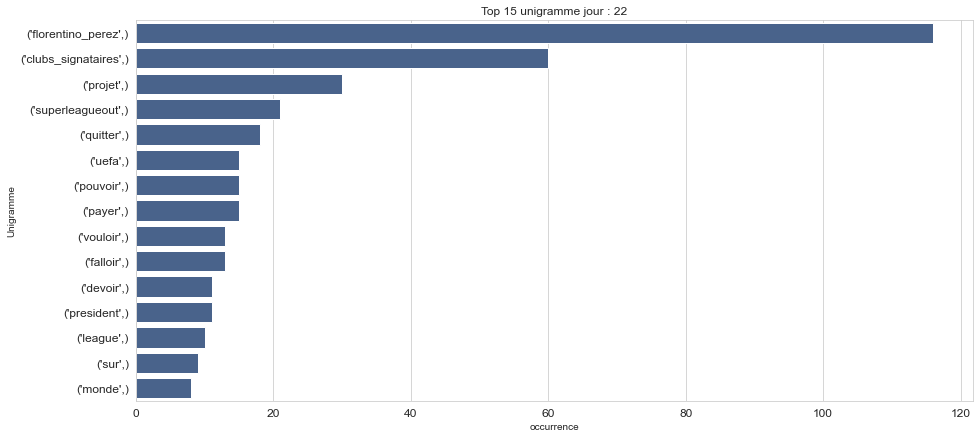

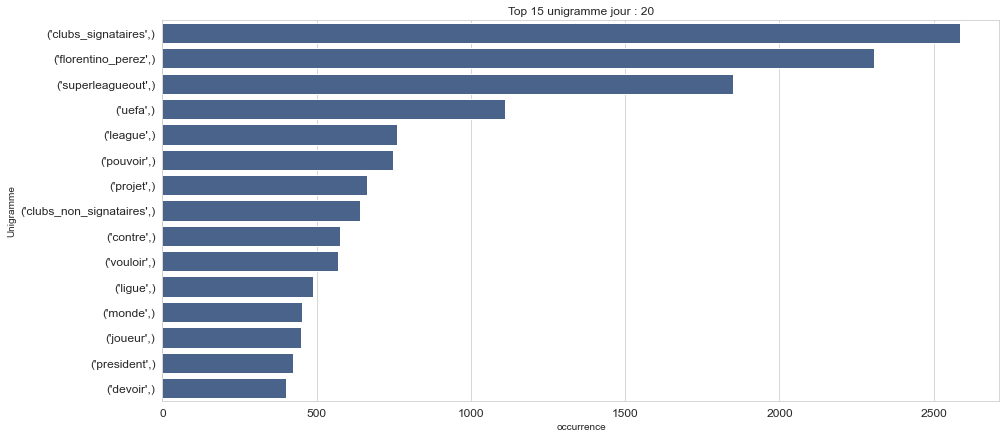

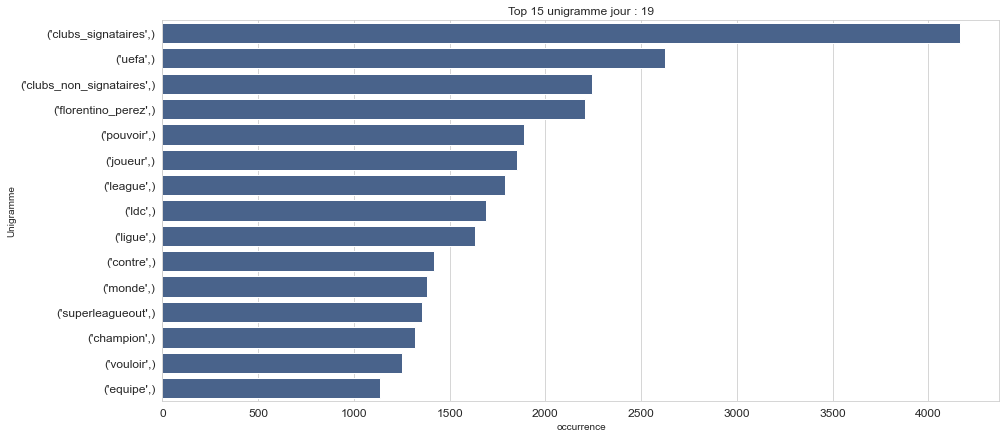

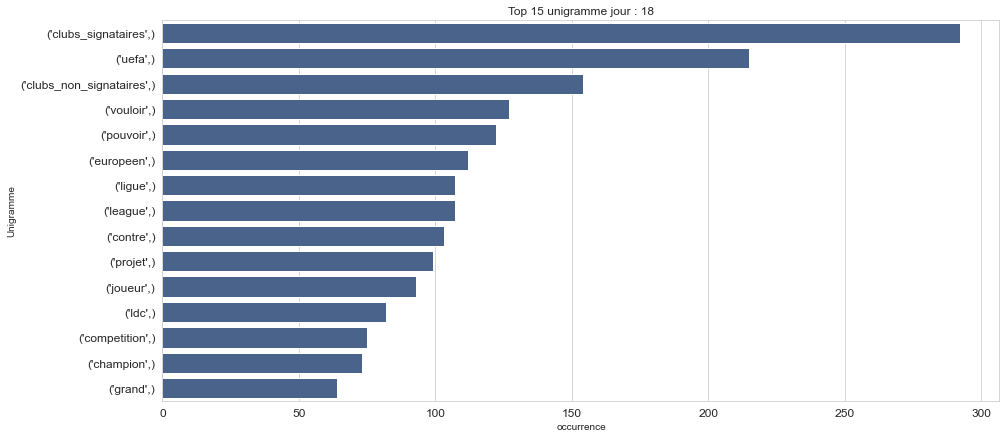

In [11]:
for day in df['day'].unique():
    
    # Récupération sous forme de liste de tous les articles
    list_tweet = df[df['day']==day]["tweet_clean"].dropna().tolist()

    # Tokenisation des articles
    list_tokens = ' '.join(list_tweet).split()

    # Identification et compte des bigrams
    list_bigrams = list(ngrams(list_tokens, 1)) 
    counter = Counter(list_bigrams)

    
    
    # Création d'un dataframe contenant le top 15 bigramme les plus fréquents
    df_plot = pd.DataFrame(counter.most_common(15))
    
    # Création du graphique
    plt.figure(figsize=(15,7))

    plot = sns.barplot(x=df_plot[1], 
                       y=df_plot[0],
                       color='#3e6096')

    plt.xlabel('occurrence')
    plt.ylabel("Unigramme")
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.title(f"Top 15 unigramme jour : {day}") 

#### Bi-grams

- Identification des bi-grams les plus utilisés

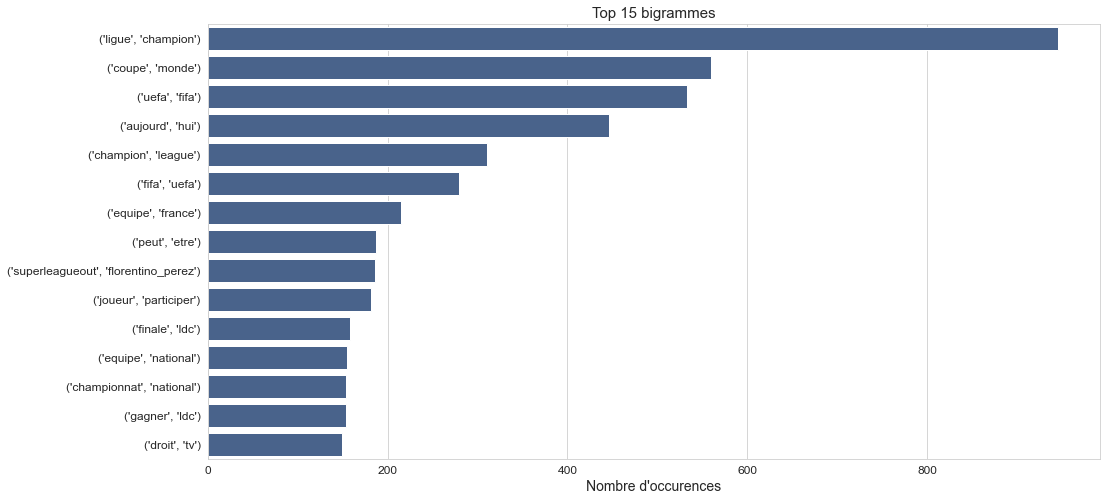

In [12]:
# Récupération sous forme de liste de tous les articles
list_tweet = df["tweet_clean"].tolist()

# Tokenisation des articles
list_tokens = ' '.join(list_tweet).split()

# Identification et compte des bigrams
list_bigrams = list(ngrams(list_tokens, 2)) 
counter = Counter(list_bigrams)

# Suppression des bigrams doublons comme ('football', 'football')
drop_duplicates = {(key[0], key[1]) : value for key, value in counter.items() if key[0] != key[1]}
counter = Counter(drop_duplicates)

# Création d'un dataframe contenant le top 15 bigramme les plus fréquents
df_plot = pd.DataFrame(counter.most_common(15))

# Création du graphique
plt.figure(figsize=(16,8))

plot = sns.barplot(x=df_plot[1], 
                   y=df_plot[0],
                   color='#3e6096')

plt.xlabel("Nombre d'occurences", fontsize = 14)
plt.ylabel("")
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)

plt.title(f"Top 15 bigrammes", fontsize = 15)
plt.savefig("../Streamlit_App/graphs/bigram.png", bbox_inches='tight', dpi = 300)

- Nos données montrent bien que notre sujet concerne les grandes compétitions internationales. On voit également que la figure de Florentino Perez est associé au terme "superleagueout".

##### Identification des bi-grams par jour

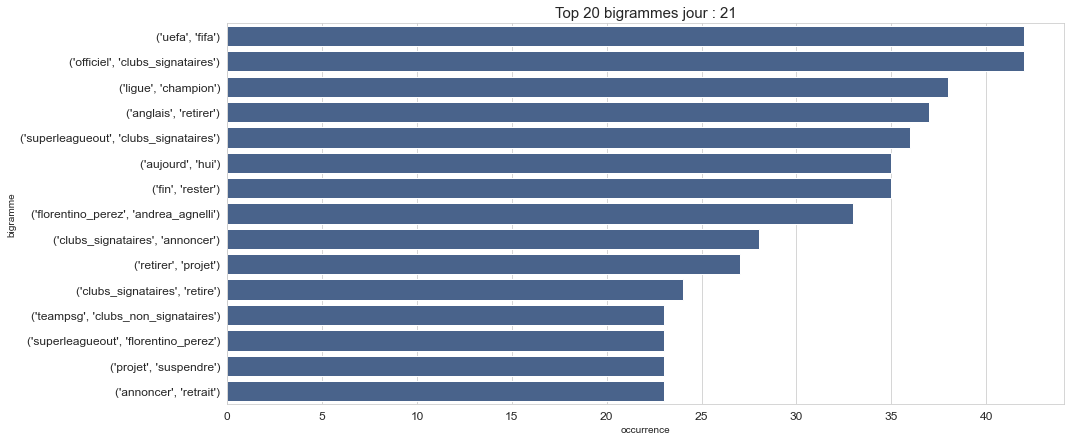

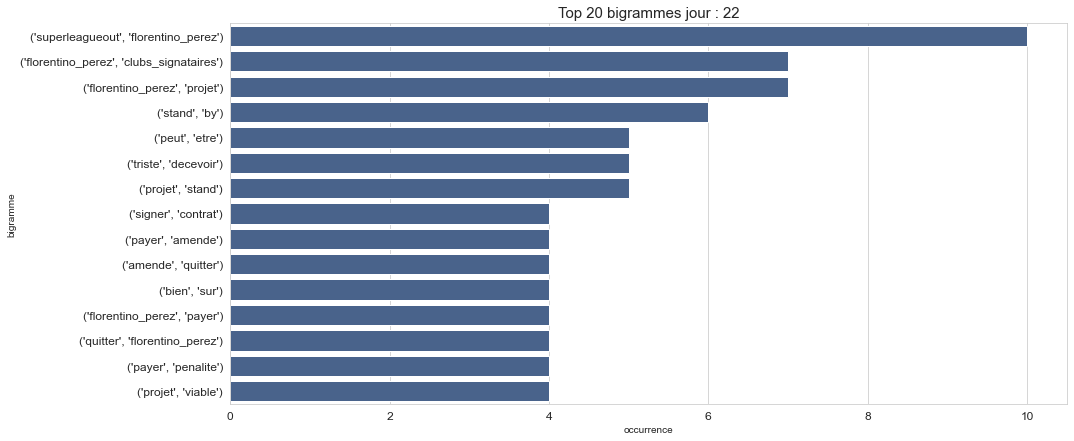

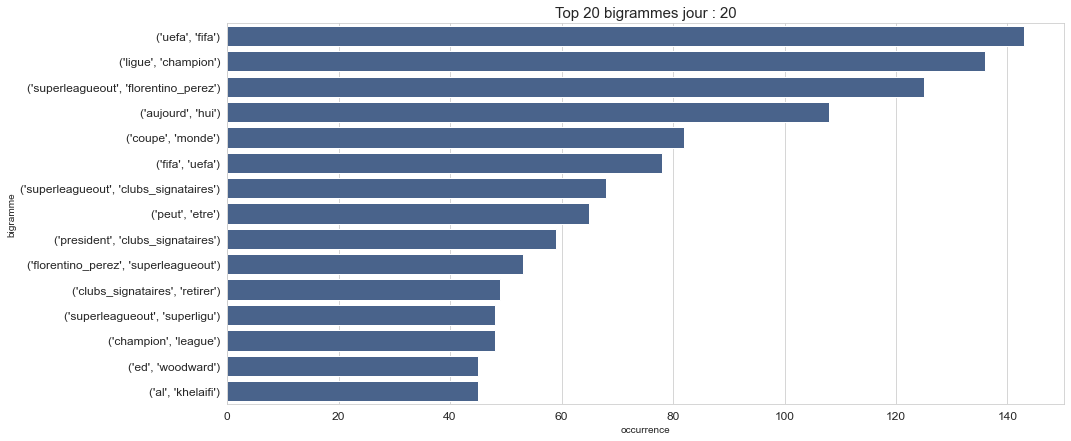

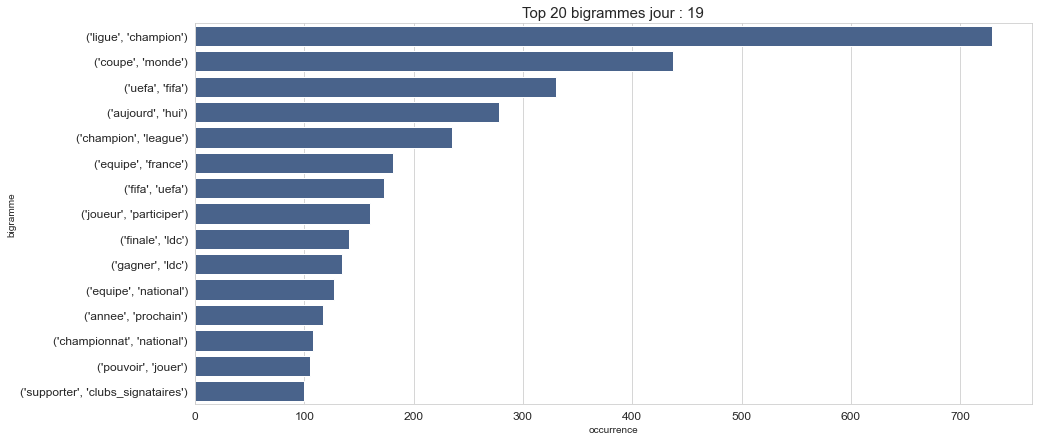

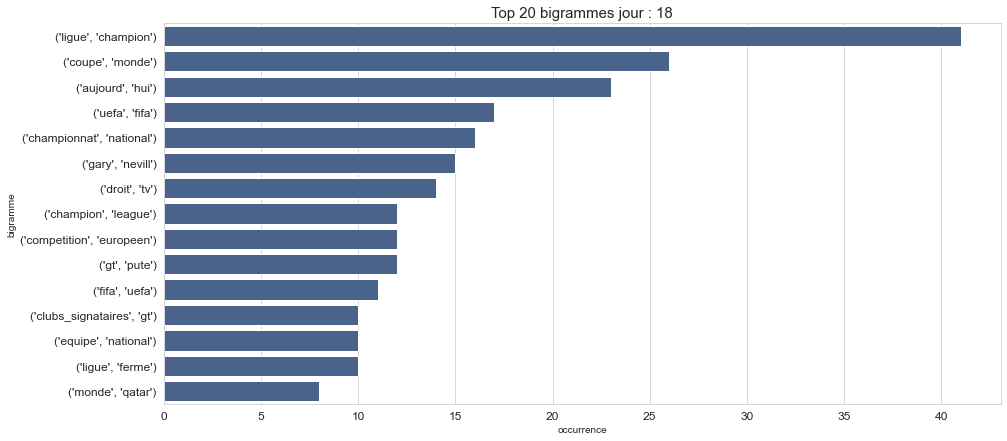

In [13]:
for day in df['day'].unique():
    
    # Récupération sous forme de liste de tous les articles
    list_tweet = df[df['day']==day]["tweet_clean"].tolist()

    # Tokenisation des articles
    list_tokens = ' '.join(list_tweet).split()

    # Identification et compte des bigrams
    list_bigrams = list(ngrams(list_tokens, 2)) 
    counter = Counter(list_bigrams)
    
    # Drop duplicate bigrams like ('superleague', 'superleague')
    drop_duplicates = {(key[0], key[1]) : value for key, value in counter.items() if key[0] != key[1]}
    counter = Counter(drop_duplicates)
    
    ## Drop  bigrams like ('a', 'b') and ('b', 'a') 
    # But doesn't work because we need to add the values
    #res = set( tuple(frozenset(sub)) for sub in set(counter) )
    
    
    # Création d'un dataframe contenant le top 15 bigramme les plus fréquents
    df_plot = pd.DataFrame(counter.most_common(15))
    
    # Création du graphique
    plt.figure(figsize=(15,7))

    plot = sns.barplot(x=df_plot[1], 
                       y=df_plot[0],
                       color='#3e6096')

    plt.xlabel('occurrence')
    plt.ylabel("bigramme")
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.title(f"Top 20 bigrammes jour : {day}", fontsize = 15) 

#### Tri-grams

Identification des tri-grams dans notre échantillon, afin de voir si l'on peut conserver 

Text(0.5, 1.0, 'Top 10 trigrammes jour')

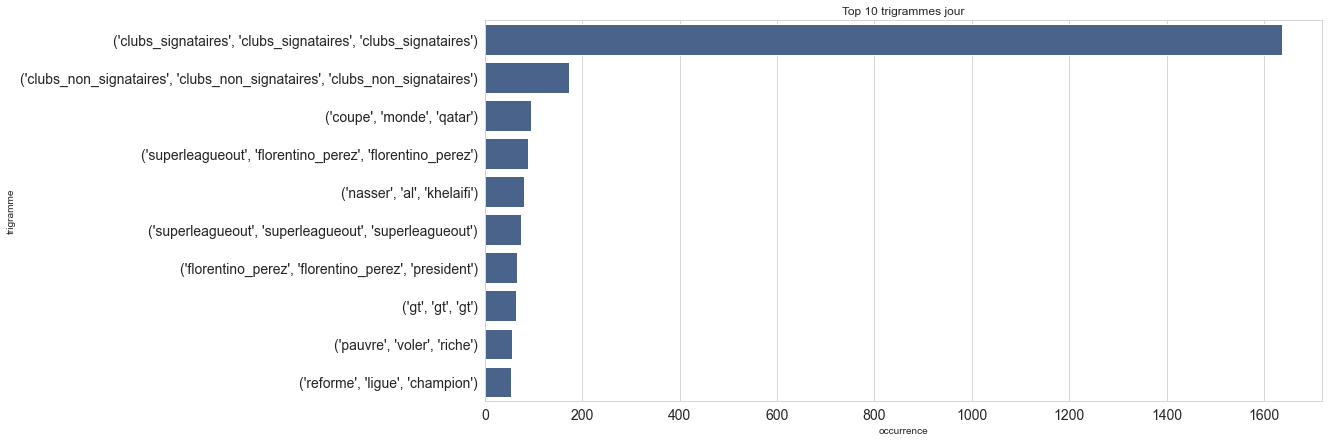

In [14]:
# Récupération sous forme de liste de tous les articles
list_tweet = df["tweet_clean"].tolist()

# Tokenisation des articles
list_tokens = ' '.join(list_tweet).split()

# Identification et compte des bigrams
list_bigrams = list(ngrams(list_tokens, 3)) 
counter = Counter(list_bigrams)

# Création d'un dataframe contenant le top 10 bigramme les plus fréquents
df_plot = pd.DataFrame(counter.most_common(10))

# Création du graphique
plt.figure(figsize=(15,7))

plot = sns.barplot(x=df_plot[1], 
                   y=df_plot[0],
                   color='#3e6096')

plt.xlabel('occurrence')
plt.ylabel("trigramme")
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.title(f"Top 10 trigrammes jour") 

#### Word-cloud

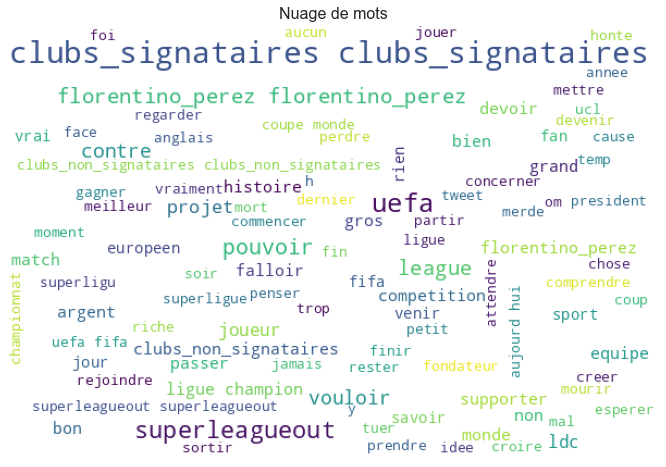

In [15]:
plt.figure(figsize=(12,8))
    
text = df["tweet_clean"].values

wordcloud_ = WordCloud(background_color='white',
                       #collocations=True, # Inclu les bigrammes -> Deux mots cotes à cotes, même couleur même taille
                       width=600,
                       height=400,
                       max_words = 100,
                       max_font_size=50,
                       stopwords=["anne", "cet",'c', 'ca', 'an', 'gro', "franc", 'etre',
                                  'faire', 'dire']).generate(" ".join(text))
                       
plt.axis('off')
plt.title(f'Nuage de mots', fontsize = 16)
plt.imshow(wordcloud_)
plt.savefig("../Streamlit_App/graphs/wordcloud.png")

### Utilisation de la librairie Spacy pour identifier les clubs et les personnalités

#### Comptage du nombre d'occurence des personnalités cités dans les tweets

- Utilisation de la librairie Spacy afin d'identifier les individus dans nos tweets
- Ici, nous réutilisons les données brutes, et effectuons un cleaning relativement simple et rapide, afin de garder nos données dans leur état d'origine et plus facilement retrouver les données qui nous intéressent. En effet, le processus de lemmatisation tend à compliquer légèrement cette tâche.

In [16]:
df_spacy = df[['tweet', 'likes_count', 'retweets_count']]

In [17]:
nlp = spacy.load("fr_core_news_md")

def tweet_cleaner_bis(pandasSeries):
    
    print("#### Nettoyage en cours ####") 
    
    # Confirmation que chaque article est bien de type str
    pandasSeries = pandasSeries.apply(lambda x : str(x))
    
    # Passage en minuscule
    print("... Passage en minuscule") 
    pandasSeries = pandasSeries.apply(lambda x : x.lower())
    
    # Suppression des accents
    print("... Suppression des accents") 
    pandasSeries = pandasSeries.apply(lambda x : unidecode(x))
    
    # Suppression des url #
    print("... Suppression des url") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"http\S+", '', x))
    
    # Suppression des mentions hashtags #
    print("... Suppression des hashtags") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"#", '', x))
    
    # Suppression des @
    print("... Suppression des hashtags") 
    pandasSeries = pandasSeries.apply(lambda x :re.sub(r"@", '', x))
    
    print("#### Nettoyage OK! ####")

    return pandasSeries


df_spacy['tweet_clean'] = tweet_cleaner_bis(df_spacy.tweet)
df_spacy.head(10)

#### Nettoyage en cours ####
... Passage en minuscule
... Suppression des accents
... Suppression des url
... Suppression des hashtags
... Suppression des hashtags
#### Nettoyage OK! ####


/var/folders/ff/1c0cg3ts35bgty96d6kxvdp00000gn/T/ipykernel_96279/847766408.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spacy['tweet_clean'] = tweet_cleaner_bis(df_spacy.tweet)


,tweet,likes_count,retweets_count,tweet_clean
date,,,,
2021-04-21,Jean Michel incisif face aux 12 frondeurs de la #SuperLeague @EtienneLantier2 @MalikaKwiatko13 #teamOm ça sera jamais plus comme avant.....,5,1,jean michel incisif face aux 12 frondeurs de la superleague etiennelantier2 malikakwiatko13 teamom ca sera jamais plus comme avant...
2021-04-21,Beppe #Marotta (AD Inter) lance un cri d’alarme : “Faire des excuses pour la #SuperLeague ? La bonté de cette action vient du fait que l...,56,18,"beppe marotta (ad inter) lance un cri d'alarme : ""faire des excuses pour la superleague ? la bonte de cette action vient du fait que les..."
2021-04-21,"Avec l'échec du projet de #SuperLeague, la mort du football a un nouveau visage. #OLASM https://t.co/Y2pgfs0F1m",6,0,"avec l'echec du projet de superleague, la mort du football a un nouveau visage. olasm"
2021-04-21,Jean Michel trop heureux de la mort de la #SuperLeague @EtienneLantier2 @MalikaKwiatko13 #teamOm https://t.co/qqAcT3rLr4,7,0,jean michel trop heureux de la mort de la superleague etiennelantier2 malikakwiatko13 teamom
2021-04-21,3-1 pour la Juve contre Parme (2 Coupes UEFA) et les gens ne comprennent toujours pas qu'on a besoin de #SuperLeague ?,2,2,3-1 pour la juve contre parme (2 coupes uefa) et les gens ne comprennent toujours pas qu'on a besoin de superleague ?
2021-04-21,48 heures pour monter un restaurant n'a rien d'insurmontable. Y en a qui ont monté et démonté une #Superleague en autant de temps #TopChef,4,0,48 heures pour monter un restaurant n'a rien d'insurmontable. y en a qui ont monte et demonte une superleague en autant de temps topchef
2021-04-21,Alors l’@UEFAcom_fr vous voulez sanctionner les 12 clubs de la superleague comme si ils avaient commis un crime mais quand il s’agit de ...,1,0,alors l'uefacom_fr vous voulez sanctionner les 12 clubs de la superleague comme si ils avaient commis un crime mais quand il s'agit de r...
2021-04-21,Aulas salue le travail de Nasser al-Khelaifi contre la Superleague #TeamPSG #PSG #Superleague https://t.co/vImHgIHsOk https://t.co/p...,59,6,aulas salue le travail de nasser al-khelaifi contre la superleague teampsg psg superleague
2021-04-21,"Les présidents du Bayern, de l'Ajax, de Porto ont le droit de s'exprimer sur la champions league ou la super ligue. @JM_Aulas et #Nasse...",0,0,"les presidents du bayern, de l'ajax, de porto ont le droit de s'exprimer sur la champions league ou la super ligue. jm_aulas et nasser ..."


In [18]:
def match_many_patterns(many_patterns):
    """
    Fonction ayant pour but d'identifier plusieurs personnes ou clubs selon leurs differents alias.
    La fonction prend comme input un ou des tupples contenant les différents alias pour l'individus concerné.
    Le premier élément du tuple est utilisé pour identifier de façon unique l'individu ou le club.
    """
    # Fonction de Spacy permettant de "matcher" selon plusieurs termes
    matcher = PhraseMatcher(nlp.vocab)
    
    # Boucle effectué sur un tupple, ou une list de tupple
    for pattern in many_patterns:
        # La premiere valeur du tupple va permettre d'identifier le nom
        name = pattern[0]
        # On récupère chaque alias
        name_alias = [nlp.make_doc(i) for i in pattern]
        
        # Ajoute les differents alias à la fonction matcher, et sera identifier par la variable "name"
        matcher.add(name.upper(), None, *name_alias)

    dico = {}
    for tweet in nlp.pipe(df_spacy['tweet_clean'], disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):# Iterate over the matches
        matches = matcher(tweet)
        # Utilise un dictionnaire pour supprimer les doubles match (ex : "florentino perez" --> 1 seul match)
        unique_match =  {i[0]:[i[1], i[2]] for i in matches}
        unique_match = [(key, value[0], value[1])  for key, value in unique_match.items()]
        
        # la fonction match renvoie un id, et l'endroit ou le mot apparait dans la phrase
        for match_id, start, end in unique_match:
            # Sélectionne le match dans le tweet
            matched_span = tweet[start:end]
            # On distingue le cas ou le match ne s'est jamais produit, alors on rajoute une key dans le dictionnaire
            # ou bien cette valeur existe déja et on rajoute 1
            if nlp.vocab.strings[match_id] not in dico:
                dico[nlp.vocab.strings[match_id]] = 1
            else:
                dico[nlp.vocab.strings[match_id]] += 1
    
    return dico

In [19]:
PATTERN = [('perez', 'florentino', 'florentinoperez'), ('agnelli', 'andrea', 'andreaagnelli'),
           ('zidane', 'zinedine', 'zinedinezidane', 'zizou'), ('messi', 'lionel messi'), ('ronaldo', 'cristiano ronaldo'),
           ('nasser', 'khelaifi', 'al-khelaifi', 'alkhelaifi', 'elkhalaifi'), ('guardiola', 'pep')
          ]
graph1 = match_many_patterns(PATTERN)
graph1

{'NASSER': 394,
 'PEREZ': 3374,
 'AGNELLI': 383,
 'ZIDANE': 162,
 'MESSI': 325,
 'GUARDIOLA': 94,
 'RONALDO': 167}

In [20]:
graph1 = pd.DataFrame(graph1.values(),  index = graph1.keys()).reset_index()
graph1.columns = ['Personnalité', 'Occurences']
graph1 = graph1.sort_values('Occurences', ascending=False)

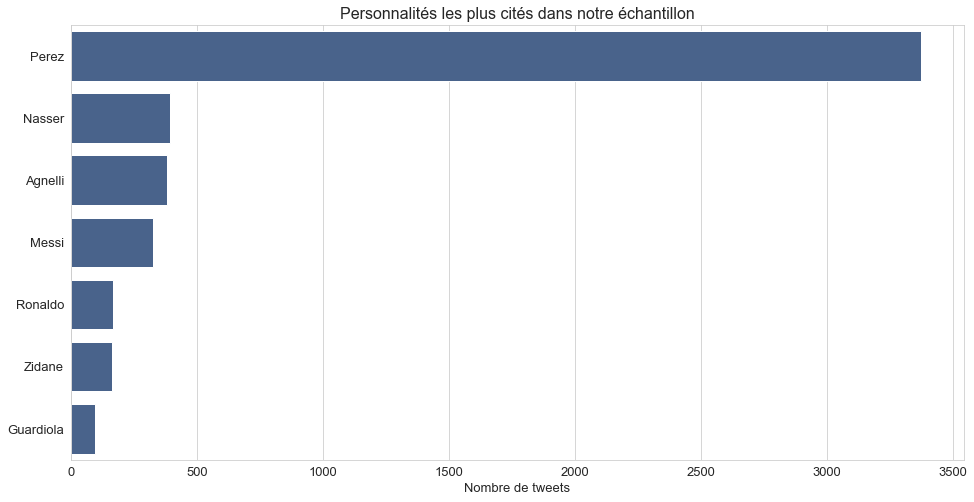

In [21]:
# Création du graphique
plt.figure(figsize=(16,8))

plot = sns.barplot(x=graph1['Occurences'], 
                   y=graph1['Personnalité'].str.capitalize(),
                   color='#3e6096')

plt.xlabel('Nombre de tweets', fontsize = 13)
plt.ylabel("")
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
plt.title("Personnalités les plus cités dans notre échantillon", fontsize = 16) 
plt.savefig("../Streamlit_App/graphs/personnalites.png")

- Florentino Perez est sans conteste la personnalité qui ressort de notre échantillon. 
    Ainsi il apparait dans un peu moins de 10% des tweets, ce qui est significativement beaucoup plus élevé que pour les autres dirigeants, joueurs, ou entraineurs qui apparaissent dans nos données. Cela n'est pas une surprise étant donné qu'il est à l'initiative du projet.

### Identification des clubs

In [22]:
PATTERN = [('arsenal', 'gunners', 'gunner'),  ('chelsea', 'chelseafc', 'chelseer'), ('liverpool', 'fcliverpool'),
                ('city', 'manchestercity', 'mancity'), ('manchester', 'manchesterunited', 'manutd', 'mufc','united'),
               ('tottenham', 'spur', 'spurs'),('inter', 'intermilan'),
                ('juventus', 'juventu', 'juventusfc', 'juv', 'juve', 'turin'),
               ('acmilan',  'milan','milanac'), ('atletico', 'atleti', 'athletico'),
               ('barca','barcelona', 'barcelone',  'fcbarca', 'fcbarcelone', 'fcbarcelona'),
                ('real', 'realmadrid', 'realmadridfrer', 'madrid'),
          
          ('psg', 'paris'), ('bayern', 'munich', 'fcbayern'), ('borussia', 'dortmund')]

clubs = match_many_patterns(PATTERN)
clubs

{'INTER': 283,
 'JUVENTUS': 697,
 'PSG': 2189,
 'BAYERN': 673,
 'REAL': 1636,
 'LIVERPOOL': 508,
 'CITY': 837,
 'ACMILAN': 403,
 'MANCHESTER': 689,
 'BARCA': 838,
 'CHELSEA': 718,
 'TOTTENHAM': 351,
 'BORUSSIA': 188,
 'ATLETICO': 307,
 'ARSENAL': 895}

In [23]:
graph2 = pd.DataFrame(clubs.values(),  index = clubs.keys()).reset_index()
graph2.columns = ['Clubs', 'Occurences']
graph2 = graph2.sort_values('Occurences', ascending=False)

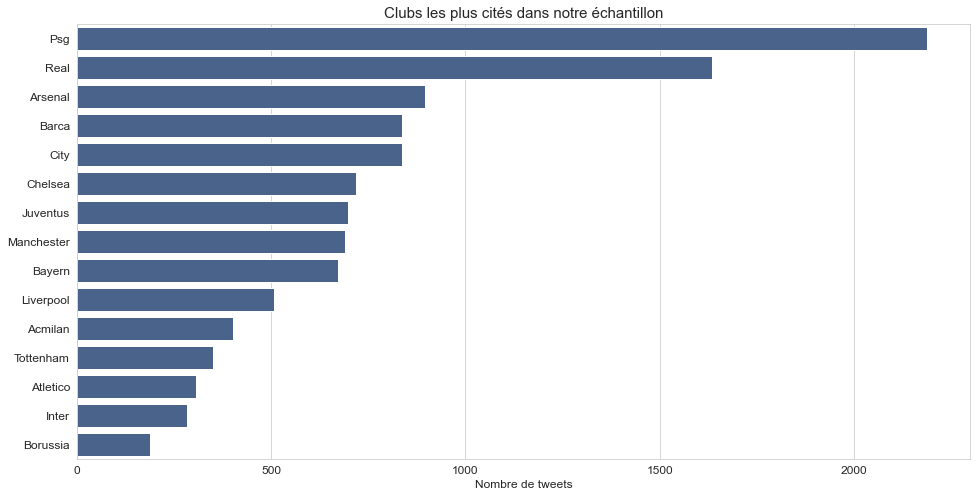

In [25]:
# Création du graphique
plt.figure(figsize=(16,8))

plot = sns.barplot(x=graph2['Occurences'], 
                   y=graph2['Clubs'].str.capitalize(),
                   color='#3e6096')

plt.xlabel('Nombre de tweets', fontsize = 12)
plt.ylabel("")
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.title("Clubs les plus cités dans notre échantillon", fontsize = 15) 
plt.savefig("../Streamlit_App/graphs/clubs.png", bbox_inches='tight', dpi = 300)

- Le PSG est le club le plus cité, ce qui n'est pas étonnant étant donné que nous avons restreint notre analyse aux tweets français.
- Le second club qui se détache de façon significative est le Réal. Cela est lié au fait que Florentino Perez, l'homme à l'initiative du projet est également président de ce club.
- Le PSG, le Bayern et le Borussia sont les seuls clubs non signataires du projet. Les autres clubs ont eux signé ce projet.

### Analyse des emojis utilisés

In [26]:
def extract_emojis(tweet):
    tweet =" ".join(tweet)
    tokens = word_tokenize(tweet)
    emojis = [i for i in tokens if i in emoji.UNICODE_EMOJI]
    return emojis

emojis = extract_emojis(df_spacy['tweet'])
Counter(emojis).items()

dict_items([('😬', 27), ('😝', 1), ('😁', 54), ('👀', 102), ('🇪🇸', 125), ('🇮🇹', 131), ('🤡', 70), ('🤦\u200d♂️', 22), ('👉', 97), ('🤔', 205), ('🔴', 419), ('➡', 27), ('👊', 32), ('✊', 13), ('💪', 25), ('🚨', 414), ('🙌', 12), ('⚡', 3), ('🤷🏿\u200d♂️', 2), ('📺', 13), ('📂', 11), ('🧐', 27), ('🏆', 72), ('💯', 2), ('🇫🇷', 90), ('⚽', 155), ('⏱', 4), ('🏁', 1), ('🤭', 16), ('🏴\U000e0067\U000e0062\U000e0065\U000e006e\U000e0067\U000e007f', 141), ('💸', 16), ('👎', 10), ('👏', 30), ('🎨', 2), ('📸', 35), ('😃', 8), ('😂', 459), ('❌', 108), ('🙏🏼', 11), ('▶️', 15), ('🔵', 7), ('❤️', 83), ('😅', 164), ('👋', 13), ('🦢', 1), ('🗨️', 7), ('😳', 31), ('🙄', 75), ('🗣', 39), ('⚪', 2), ('🍻', 2), ('😍', 39), ('💥', 29), ('😊', 14), ('🗣️', 39), ('🤣', 166), ('📄', 14), ('▪️', 16), ('💰', 55), ('😑', 12), ('📆', 4), ('🗓', 1), ('😭', 212), ('❤', 31), ('🔥', 64), ('🥂', 1), ('🤩', 32), ('🇩🇪', 37), ('😋', 13), ('🙃', 38), ('🤮', 61), ('😏', 54), ('🗞️', 20), ('✍️', 8), ('⬇️', 56), ('🎙', 44), ('👨🏼', 1), ('👇', 102), ('📃', 2), ('🎙️', 23), ('😒', 16), ('😶', 11),

In [27]:
emoji_compte = (Counter(emojis).items())
df_emoji = pd.DataFrame(emoji_compte,columns=['emoji','occurrences'])

df_emoji.sort_values(by='occurrences',ascending=False).reset_index(drop = True).head(10)

,emoji,occurrences
0,😂,459
1,🔴,419
2,🚨,414
3,😭,212
4,🤔,205
5,🤣,166
6,😅,164
7,⚽,155
8,🏴󠁧󠁢󠁥󠁮󠁧󠁿,141
9,🇮🇹,131


- On retrouve un emoji rouge, comme pour signaler un stop ou un carton rouge, ou la colère ?
- Une alarme, comme pour signaler une nouvelle importante.
- Du rire et des larmes également.
- Un ballon de foot
- Le drapeau anglais, sachant qu'ils ont été ceux parmi les premiers à s'être retirer du projet